In [576]:
import os
import numpy as np
import pandas as pd
import torchvision
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

# Create custom dataset

In [562]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):        
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):        
        return len(self.img_labels)

    def __getitem__(self, idx):        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]       
        if self.transform:
            image = self.transform(image)           
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

# Load training data

In [563]:
annotations_file = 'train_labels.csv'
img_dir_train = 'train_set/train_set'
img_dir_test = 'test_set/test_set'

transform = torchvision.transforms.Compose([
    transforms.Resize((28, 28))
])

dataset = CustomImageDataset(annotations_file, img_dir_train, transform)

# Display image and label

Feature batch shape: torch.Size([64, 3, 28, 28])
Labels batch shape: torch.Size([64])


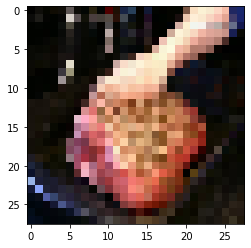

Label: 8


In [564]:
# load images as PIL
train_dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

# only works when the transform ToTensor() is not applied
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# don't really know what permute does, but it works
img = train_features[0].squeeze().permute(1, 2, 0)
label = train_labels[0]

plt.imshow(img, cmap = 'gray')
plt.show()

print(f"Label: {label}")

# Train model

In [571]:
# split train set into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_subset, val_subset = torch.utils.data.random_split(
        dataset, [train_size, val_size], generator = torch.Generator().manual_seed(1))

batch_size = 64

train_dataloader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_subset, batch_size = batch_size, shuffle = True)

In [572]:
# cuda or cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


# Neural network

In [573]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2352, 1800),
            nn.ReLU(),
            nn.Linear(1800, 1500),
            nn.ReLU(),
            nn.Linear(1500, 1200),
            nn.ReLU(),
            nn.Linear(1200, 800),
            nn.ReLU(),
            nn.Linear(800, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 81),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

In [574]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float()) # only works when X is a float
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # update parameters / weights

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss: > 7f}  [{current: > 5d} / {size: > 5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float()) # only works when X is a float
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100 * correct): > 0.1f}%, Avg loss: {test_loss: > 8f} \n")

# How well does the model perform?

In [575]:
learning_rate = 0.001
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1} \n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
    
print("Done!")

Epoch 1
-------------------------------
loss: 4.383621  [    0/24489]
loss: 4.383384  [ 6400/24489]
loss: 4.419337  [12800/24489]
loss: 4.387862  [19200/24489]
Test Error: 
 Accuracy: 1.5%, Avg loss: 4.379148 

Epoch 2
-------------------------------
loss: 4.389859  [    0/24489]
loss: 4.380431  [ 6400/24489]
loss: 4.390921  [12800/24489]
loss: 4.377818  [19200/24489]
Test Error: 
 Accuracy: 1.9%, Avg loss: 4.366914 

Epoch 3
-------------------------------
loss: 4.331046  [    0/24489]
loss: 4.376426  [ 6400/24489]
loss: 4.388202  [12800/24489]
loss: 4.331815  [19200/24489]
Test Error: 
 Accuracy: 2.0%, Avg loss: 4.350410 

Epoch 4
-------------------------------
loss: 4.347972  [    0/24489]
loss: 4.294960  [ 6400/24489]
loss: 4.375929  [12800/24489]
loss: 4.280212  [19200/24489]
Test Error: 
 Accuracy: 2.9%, Avg loss: 4.330817 

Epoch 5
-------------------------------
loss: 4.255974  [    0/24489]
loss: 4.236732  [ 6400/24489]
loss: 4.304360  [12800/24489]
loss: 4.272893  [19200/244